# Image classification

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm, trange

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# CNN for image classification (CIFAR10)

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./cifar",
    train=True,
    download=True,
    transform=transform
)

valset = torchvision.datasets.CIFAR10(
    root="./cifar",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=16,
    shuffle=True,
    num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    valset,
    batch_size=16,
    shuffle=False,
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Grays")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

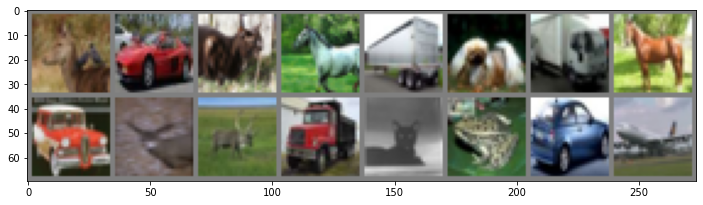

In [10]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)

In [11]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)
    steps = list(range(0, len(train_history)+1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [14]:
images.shape

torch.Size([16, 3, 32, 32])

In [32]:
# VGG
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        # VGG Block
        self.vgg_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully conncted
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU(),
        )

        # Softmax
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.vgg_block(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [48]:
# Train cycle
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0) 
        model.train()

        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_epoch_loss = torch.cat((train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits,
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])


        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Vaidating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits, 
                    (pred_classes == labels.cpu()).sum().unsqueeze(0)
                ))

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
              "Train acc:",
              (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )

In [49]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)                                  

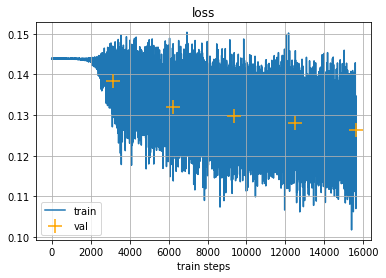

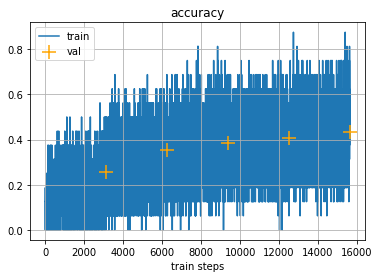

Train loss: 0.12731671333312988
Train acc: 0.4215199947357178
Val loss: 0.12639981508255005
Val acc: 0.4343999922275543


In [50]:
train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

In [52]:
!pip install filter_viz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement filter_viz (from versions: none)
ERROR: No matching distribution found for filter_viz


In [ ]:
from filter_viz import plot_filters

In [ ]:
model_baseline

In [ ]:
model_baseline.cpu()